In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split



In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate



2023-11-16 11:02:47.053903: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 11:02:47.110089: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 11:02:51.439709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [4]:
#ensure that TensorFlow can access local GPUs

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)


Load Parquet Data

In [5]:
small_set_data = pd.read_parquet("data/Zzzs_train.parquet")

In [6]:
data_series = {}
for series in set(small_set_data["series_id"]):
    data_series[series] = small_set_data[small_set_data["series_id"] == series]

In [17]:
def create_non_overlapping_section(data,feature,timestep_interval_in_sec,window_length_by_hr):
    window_size = window_length_by_hr * 60 * 60 / timestep_interval_in_sec
    column_names = ["local step " + str(i) for i in range(window_size)]
    column_names = ["series_id", "global first step num", "global first timestamp","num_day"]+column_names
    column_names = column_names + ["awake","wakeup","fallasleep","asleep"]
    windowed_data = []
    dummy_counter = 10
    num_sections = len(data) // window_size
    for i in range(len(data) - window_size + 1):
        current_row = list(data.iloc[i,0:3]) + list(data[feature].iloc[i:i+window_size])
        #print(i, sum(data["enmo"][i:i+window_size]))
        if sum(data["awake"].iloc[i:i+window_size]) >= window_size - buffer: #Therefore during a time window, if the majority of the timesteps are
            #awake then the window is defined as awake; it does not matter if the window started with awake as 0, or 1.
            state = [1,0,0,0]
        elif sum(data["awake"].iloc[i:i+window_size]) <= buffer:   
            state = [0,0,0,1]
        elif data["awake"].iloc[i] == 1:   
            state = [0,0,1,0]
        elif data["awake"].iloc[i] == 0:   
            state = [0,1,0,0] 
        current_row += state
        #print(len(current_row))
        #print(current_row)
        #print(type(windowed_data))
        windowed_data.append(current_row)
        if (i*100) // (len(data) - window_size + 1) % 10 == 0 and (i  * 100 )// (len(data) - window_size + 1) != 0 and (i*100) // (len(data) - window_size + 1) >= dummy_counter:
            print(f"series {data.iloc[i,0]}  completed: {(i*100) // (len(data) - window_size + 1)} %")
            dummy_counter += 10
    windowed_data = pd.DataFrame(windowed_data, columns=column_names) #windowed_data.append(pd.Series(current_row, index=windowed_data.columns), ignore_index=True)
        
    return windowed_data
    
        
        
        
    

In [8]:
# Function to convert timestamp string to sinusoidal wave representation
def convert_to_sine_wave(timestamp_str):
    timestamp_dt = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S%z")
    time_in_hours = timestamp_dt.hour + timestamp_dt.minute / 60  # Convert minute to fraction of an hour
    return np.sin(2 * np.pi * time_in_hours / 24)  # 24 hours is the period


In [9]:
# Function to convert timestamp string to numerical value
def convert_to_numerical(timestamp_str):
    timestamp_dt = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S%z")
    return timestamp_dt.hour * 100 + timestamp_dt.minute

In [11]:
# Iterate through the dictionary and modify each DataFrame
from datetime import datetime
for key, df in data_series.items():
    df_copy = df.copy()
    # Apply the custom function to the specified feature and create a new column
    df_copy['sinusoidal_time'] = df_copy['timestamp'].apply(convert_to_sine_wave)
    df_copy['numerical_time'] = df_copy['timestamp'].apply(convert_to_numerical)
    data_series[key] = df_copy

In [ ]:

window_size = 50
buffer_percentage = 10
variable_list = ['anglez','enmo','sinusoidal_time','sinusoidal_time']
windowed_dataset = {}
for variable in variable_list:
    windowed_dataset[variable] = pd.DataFrame()

    for series in set(small_set_data["series_id"]):
     
        windowed_series = create_sliding_windows_W_buffer(data_series[series],window_size = window_size,buffer=(window_size * buffer_percentage / 100),feature = variable)   
        windowed_dataset[variable] = pd.concat([windowed_dataset[variable], windowed_series], ignore_index=True)

series 67f5fc60e494  completed: 10 %
series 67f5fc60e494  completed: 20 %
series 67f5fc60e494  completed: 30 %
series 67f5fc60e494  completed: 40 %
series 67f5fc60e494  completed: 50 %
series 67f5fc60e494  completed: 60 %
series 67f5fc60e494  completed: 70 %
series 67f5fc60e494  completed: 80 %
series 67f5fc60e494  completed: 90 %
series a9a2f7fac455  completed: 10 %
series a9a2f7fac455  completed: 20 %
series a9a2f7fac455  completed: 30 %
series a9a2f7fac455  completed: 40 %
series a9a2f7fac455  completed: 50 %
series a9a2f7fac455  completed: 60 %
series a9a2f7fac455  completed: 70 %
series a9a2f7fac455  completed: 80 %
series a9a2f7fac455  completed: 90 %
series c6788e579967  completed: 10 %
series c6788e579967  completed: 20 %
series c6788e579967  completed: 30 %
series c6788e579967  completed: 40 %
series c6788e579967  completed: 50 %
series c6788e579967  completed: 60 %
series c6788e579967  completed: 70 %
series c6788e579967  completed: 80 %
series c6788e579967  completed: 90 %
s

In [ ]:
#Loading Data

# Load data from the first CSV file
#file_path1 = 'data/windowed_sequences/50_small_set_enmo_windowed.csv'

#file_path2 = 'data/windowed_sequences/50_small_set_anglez_windowed.csv'

#file1_data = pd.read_csv(file_path1)#, dtype=np.float32)

# Set the first column as the index
#file1_data.set_index(file1_data.columns[0], inplace=True)

# Convert the DataFrame to a NumPy array
drop_columns = ["series_id", "global first step num", "global first timestamp", "awake","wakeup","fallasleep","asleep"]

variable_data = []
for variable in variable_list:
    df_copy = windowed_dataset[variable].copy()
    data_array = df_copy.drop(columns=drop_columns).values
    variable_data.append(data_array)
    
#file1_array = file1_data.drop(columns=drop_columns).values

# Load data from the second CSV file
#file2_data = pd.read_csv(file_path2)

#file2_array = file2_data.drop(columns=drop_columns).values
df_copy = windowed_dataset[variable_list[0]].copy()
data_identity_storage = df_copy[["series_id", "global first step num", "global first timestamp"]]
df_Y = df_copy.iloc[:, -4:]
Y_all = df_Y.values
# Check shapes
for i in range(len(variable_data)-1):
    assert variable_data[i].shape == variable_data[i+1].shape, "Arrays should have the same shape"


# Create 3D array
three_d_array = np.stack(variable_data, axis=2)


In [ ]:
# Extract indices from the original 3D array
indices_list = list(range(three_d_array.shape[0]))

In [ ]:


# Split the data and indices into training and validation sets
indices_train, indices_val, X_train, X_val, Y_train, Y_val = train_test_split(
    indices_list, three_d_array, Y_all, test_size=0.2, random_state=42, stratify=Y_all
)

# Check the shapes of the training and validation sets
print("indices_train shape:", len(indices_train))
print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("indices_val shape:", len(indices_val))
print("X_val shape:", X_val.shape)
print("y_val shape:", Y_val.shape)

In [ ]:
'''
# Adjust the size of the subset based on your computational resources
subset_percentage = 10
subset_size = X_train.shape[0] // 100 * subset_percentage

# Split the data into a subset and the rest
subset_X, remaining_X, subset_Y, remaining_Y = train_test_split(X_train, Y_train, test_size=subset_size, random_state=42, stratify=Y_train)

# Confirm the shapes of the subsets
print("Subset X shape:", subset_X.shape)
print("Remaining X shape:", remaining_X.shape)
print("Subset y shape:", subset_Y.shape)
print("Remaining y shape:", remaining_Y.shape)

In [6]:
#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train
num_classes = labels_for_training.shape[1]

# Assuming you have sequences (X) and labels (y) for training
# X should be a 3D tensor with shape (num_samples, sequence_length, num_features)
# y should be a 2D tensor with shape (num_samples, num_classes)

sequence_length = dataset_for_training.shape[1]
num_features = dataset_for_training.shape[2]

# Define the LSTM model
input_sequence = Input(shape=(sequence_length, num_features))
#lstm_out = LSTM(units=64, return_sequences=True)(input_sequence)
lstm_out = LSTM(units=64, return_sequences=False, recurrent_initializer='glorot_uniform', implementation=2)(input_sequence)


# Define the attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Concatenate the LSTM output and attention output
merged = Concatenate(axis=-1)([lstm_out, attention])

# Fully connected layer for final prediction
output = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model = Model(inputs=input_sequence, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/37_series_LSTM64_W_attention.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/20
329096/329097 [============================>.] - ETA: 0s - loss: 1.1113 - accuracy: 0.6036
Epoch 1: val_loss improved from inf to 0.87397, saving model to model\37_series_LSTM64_W_attention.h5
329097/329097 [==============================] - 5020s 15ms/step - loss: 1.1113 - accuracy: 0.6036 - val_loss: 0.8740 - val_accuracy: 0.6648
Epoch 2/20
     9/329097 [..............................] - ETA: 1:15:10 - loss: 2.1365 - accuracy: 0.6285

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


329094/329097 [============================>.] - ETA: 0s - loss: 1.1423 - accuracy: 0.5858
Epoch 2: val_loss did not improve from 0.87397
329097/329097 [==============================] - 4841s 15ms/step - loss: 1.1422 - accuracy: 0.5858 - val_loss: 1.0700 - val_accuracy: 0.5297
Epoch 3/20
329097/329097 [==============================] - ETA: 0s - loss: 1.2416 - accuracy: 0.5249
Epoch 3: val_loss did not improve from 0.87397
329097/329097 [==============================] - 5124s 16ms/step - loss: 1.2416 - accuracy: 0.5249 - val_loss: 1.0465 - val_accuracy: 0.5773
Epoch 4/20
329096/329097 [============================>.] - ETA: 0s - loss: 1.2172 - accuracy: 0.5419
Epoch 4: val_loss did not improve from 0.87397
82275/82275 [==============================] - 473s 6ms/step - loss: 0.8740 - accuracy: 0.6648
Test Loss: 0.8739655613899231, Test Accuracy: 0.6647863984107971


In [ ]:
#LSTM = 128

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train
num_classes = labels_for_training.shape[1]

# Assuming you have sequences (X) and labels (y) for training
# X should be a 3D tensor with shape (num_samples, sequence_length, num_features)
# y should be a 2D tensor with shape (num_samples, num_classes)

sequence_length = dataset_for_training.shape[1]
num_features = dataset_for_training.shape[2]

# Define the LSTM model
input_sequence = Input(shape=(sequence_length, num_features))
#lstm_out = LSTM(units=64, return_sequences=True)(input_sequence)
lstm_out = LSTM(units=128, return_sequences=False, recurrent_initializer='glorot_uniform', implementation=2)(input_sequence)


# Define the attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Concatenate the LSTM output and attention output
merged = Concatenate(axis=-1)([lstm_out, attention])

# Fully connected layer for final prediction
output = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model = Model(inputs=input_sequence, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM128_W_attention.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/20
10106/10106 [==============================] - ETA: 0s - loss: 1.0474 - accuracy: 0.5742
Epoch 1: val_loss improved from inf to 1.04897, saving model to model\model_one_series_LSTM128_W_attention.h5
10106/10106 [==============================] - 314s 31ms/step - loss: 1.0474 - accuracy: 0.5742 - val_loss: 1.0490 - val_accuracy: 0.5644
Epoch 2/20
    7/10106 [..............................] - ETA: 4:27 - loss: 1.0160 - accuracy: 0.5536

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10104/10106 [============================>.] - ETA: 0s - loss: 0.7765 - accuracy: 0.6925
Epoch 2: val_loss improved from 1.04897 to 0.76349, saving model to model\model_one_series_LSTM128_W_attention.h5
10106/10106 [==============================] - 311s 31ms/step - loss: 0.7767 - accuracy: 0.6925 - val_loss: 0.7635 - val_accuracy: 0.6878
Epoch 3/20
10104/10106 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.7415
Epoch 3: val_loss did not improve from 0.76349
10106/10106 [==============================] - 322s 32ms/step - loss: 0.6600 - accuracy: 0.7415 - val_loss: 0.8271 - val_accuracy: 0.6661
Epoch 4/20
10105/10106 [============================>.] - ETA: 0s - loss: 0.5959 - accuracy: 0.7746
Epoch 4: val_loss improved from 0.76349 to 0.67467, saving model to model\model_one_series_LSTM128_W_attention.h5
10106/10106 [==============================] - 320s 32ms/step - loss: 0.5958 - accuracy: 0.7746 - val_loss: 0.6747 - val_accuracy: 0.7133
Epoch 5/20
10106/10106

In [9]:
loaded_model = load_model('model/model_one_series_LSTM128_W_attention.h5')

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM_W_attention.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

loaded_model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


Epoch 1/20
10106/10106 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.8244
Epoch 1: val_loss improved from inf to 0.64284, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 411s 41ms/step - loss: 0.4708 - accuracy: 0.8244 - val_loss: 0.6428 - val_accuracy: 0.7562
Epoch 2/20
    3/10106 [..............................] - ETA: 4:55 - loss: 0.2779 - accuracy: 0.7500

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10106/10106 [==============================] - ETA: 0s - loss: 0.4515 - accuracy: 0.8334
Epoch 2: val_loss improved from 0.64284 to 0.55632, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 420s 42ms/step - loss: 0.4515 - accuracy: 0.8334 - val_loss: 0.5563 - val_accuracy: 0.7928
Epoch 3/20
10104/10106 [============================>.] - ETA: 1s - loss: 0.4421 - accuracy: 0.8442
Epoch 3: val_loss improved from 0.55632 to 0.53572, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 7457s 738ms/step - loss: 0.4424 - accuracy: 0.8442 - val_loss: 0.5357 - val_accuracy: 0.8068
Epoch 4/20
10104/10106 [============================>.] - ETA: 0s - loss: 0.4275 - accuracy: 0.8484
Epoch 4: val_loss improved from 0.53572 to 0.52055, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 260s 26ms/step - loss: 0.4278 - accuracy: 0.8484 - va

In [10]:
loaded_model = load_model('model/model_one_series_LSTM128_W_attention.h5')

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM_W_attention.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

loaded_model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


Epoch 1/20
10105/10106 [============================>.] - ETA: 0s - loss: 0.4708 - accuracy: 0.8244
Epoch 1: val_loss improved from inf to 0.64284, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 248s 24ms/step - loss: 0.4708 - accuracy: 0.8244 - val_loss: 0.6428 - val_accuracy: 0.7562
Epoch 2/20
    6/10106 [..............................] - ETA: 4:12 - loss: 0.3416 - accuracy: 0.7344

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10105/10106 [============================>.] - ETA: 0s - loss: 0.4516 - accuracy: 0.8334
Epoch 2: val_loss improved from 0.64284 to 0.55632, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 257s 25ms/step - loss: 0.4515 - accuracy: 0.8334 - val_loss: 0.5563 - val_accuracy: 0.7928
Epoch 3/20
10105/10106 [============================>.] - ETA: 0s - loss: 0.4424 - accuracy: 0.8442
Epoch 3: val_loss improved from 0.55632 to 0.53572, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 257s 25ms/step - loss: 0.4424 - accuracy: 0.8442 - val_loss: 0.5357 - val_accuracy: 0.8068
Epoch 4/20
10105/10106 [============================>.] - ETA: 0s - loss: 0.4278 - accuracy: 0.8484
Epoch 4: val_loss improved from 0.53572 to 0.52055, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 267s 26ms/step - loss: 0.4278 - accuracy: 0.8484 - val_

In [11]:
#LSTM = 32

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train
num_classes = labels_for_training.shape[1]

# Assuming you have sequences (X) and labels (y) for training
# X should be a 3D tensor with shape (num_samples, sequence_length, num_features)
# y should be a 2D tensor with shape (num_samples, num_classes)

sequence_length = dataset_for_training.shape[1]
num_features = dataset_for_training.shape[2]

# Define the LSTM model
input_sequence = Input(shape=(sequence_length, num_features))
#lstm_out = LSTM(units=64, return_sequences=True)(input_sequence)
lstm_out = LSTM(units=32, return_sequences=False, recurrent_initializer='glorot_uniform', implementation=2)(input_sequence)


# Define the attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Concatenate the LSTM output and attention output
merged = Concatenate(axis=-1)([lstm_out, attention])

# Fully connected layer for final prediction
output = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model = Model(inputs=input_sequence, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM32_W_attention.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

model.fit(train_dataset, epochs=30, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/30
10102/10106 [============================>.] - ETA: 0s - loss: 1.1102 - accuracy: 0.5321
Epoch 1: val_loss improved from inf to 1.10313, saving model to model\model_one_series_LSTM32_W_attention.h5
10106/10106 [==============================] - 118s 12ms/step - loss: 1.1102 - accuracy: 0.5321 - val_loss: 1.1031 - val_accuracy: 0.4972
Epoch 2/30
   15/10106 [..............................] - ETA: 2:05 - loss: 0.7805 - accuracy: 0.4458

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10105/10106 [============================>.] - ETA: 0s - loss: 0.9114 - accuracy: 0.6257
Epoch 2: val_loss improved from 1.10313 to 1.00430, saving model to model\model_one_series_LSTM32_W_attention.h5
10106/10106 [==============================] - 117s 12ms/step - loss: 0.9114 - accuracy: 0.6257 - val_loss: 1.0043 - val_accuracy: 0.5861
Epoch 3/30
10103/10106 [============================>.] - ETA: 0s - loss: 0.7854 - accuracy: 0.6882
Epoch 3: val_loss improved from 1.00430 to 0.83949, saving model to model\model_one_series_LSTM32_W_attention.h5
10106/10106 [==============================] - 118s 12ms/step - loss: 0.7855 - accuracy: 0.6882 - val_loss: 0.8395 - val_accuracy: 0.6416
Epoch 4/30
10104/10106 [============================>.] - ETA: 0s - loss: 0.7302 - accuracy: 0.7150
Epoch 4: val_loss improved from 0.83949 to 0.76207, saving model to model\model_one_series_LSTM32_W_attention.h5
10106/10106 [==============================] - 117s 12ms/step - loss: 0.7304 - accuracy: 0.7150 

In [12]:
#LSTM = 256

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train
num_classes = labels_for_training.shape[1]

# Assuming you have sequences (X) and labels (y) for training
# X should be a 3D tensor with shape (num_samples, sequence_length, num_features)
# y should be a 2D tensor with shape (num_samples, num_classes)

sequence_length = dataset_for_training.shape[1]
num_features = dataset_for_training.shape[2]

# Define the LSTM model
input_sequence = Input(shape=(sequence_length, num_features))
#lstm_out = LSTM(units=64, return_sequences=True)(input_sequence)
lstm_out = LSTM(units=32, return_sequences=False, recurrent_initializer='glorot_uniform', implementation=2)(input_sequence)


# Define the attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Concatenate the LSTM output and attention output
merged = Concatenate(axis=-1)([lstm_out, attention])

# Fully connected layer for final prediction
output = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model = Model(inputs=input_sequence, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM256_W_attention.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

model.fit(train_dataset, epochs=30, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/30
10106/10106 [==============================] - ETA: 0s - loss: 1.0771 - accuracy: 0.5377
Epoch 1: val_loss improved from inf to 1.16018, saving model to model\model_one_series_LSTM256_W_attention.h5
10106/10106 [==============================] - 119s 12ms/step - loss: 1.0771 - accuracy: 0.5377 - val_loss: 1.1602 - val_accuracy: 0.4150
Epoch 2/30
   11/10106 [..............................] - ETA: 1:53 - loss: 0.8809 - accuracy: 0.4119

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10102/10106 [============================>.] - ETA: 0s - loss: 0.8545 - accuracy: 0.6343
Epoch 2: val_loss improved from 1.16018 to 0.96351, saving model to model\model_one_series_LSTM256_W_attention.h5
10106/10106 [==============================] - 117s 12ms/step - loss: 0.8546 - accuracy: 0.6343 - val_loss: 0.9635 - val_accuracy: 0.6134
Epoch 3/30
10104/10106 [============================>.] - ETA: 0s - loss: 0.7542 - accuracy: 0.6829
Epoch 3: val_loss improved from 0.96351 to 0.81235, saving model to model\model_one_series_LSTM256_W_attention.h5
10106/10106 [==============================] - 117s 12ms/step - loss: 0.7544 - accuracy: 0.6829 - val_loss: 0.8123 - val_accuracy: 0.6334
Epoch 4/30
10103/10106 [============================>.] - ETA: 0s - loss: 0.6825 - accuracy: 0.7237
Epoch 4: val_loss did not improve from 0.81235
10106/10106 [==============================] - 118s 12ms/step - loss: 0.6827 - accuracy: 0.7237 - val_loss: 1.0416 - val_accuracy: 0.5479
Epoch 5/30
10102/10106

In [10]:
loaded_model = load_model('model/model_one_series_LSTM128_W_attention.h5')
class_labels = ["awake","wakeup","fallasleep","asleep"]

# Assuming you have trained your model and obtained predictions on the validation set
# Replace 'loaded_model' with the actual reference to your trained model

# Assuming X_val and Y_val are your validation data
print(Y_val[:10,:])

y_true = np.argmax(Y_val, axis=1)
y_pred = loaded_model.predict(X_val)
y_pred_class = np.argmax(y_pred, axis=1)

print(y_true[:10])
print(y_pred_class[:10])

[[1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]]
82275/82275 [==============================] - 1026s 12ms/step
[0 0 3 0 0 0 3 3 3 0]
[0 3 0 0 0 3 0 0 0 0]


2527/2527 [==============================] - 17s 7ms/step
Confusion Matrix:
            awake  wakeup  fallasleep  asleep
awake       47826    1189         623    3499
wakeup          2     170           4      49
fallasleep     11       5         195      14
asleep       1514    4380         965   20401


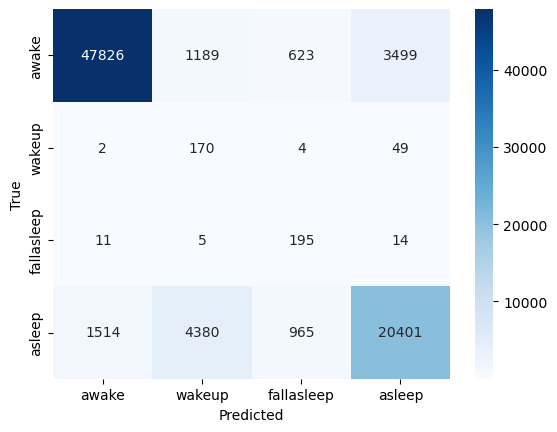

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

loaded_model = load_model('model/model_one_series_LSTM128_W_attention.h5')
class_labels = ["awake","wakeup","fallasleep","asleep"]

# Assuming you have trained your model and obtained predictions on the validation set
# Replace 'loaded_model' with the actual reference to your trained model

# Assuming X_val and Y_val are your validation data
Y_val.head()

y_true = np.argmax(Y_val, axis=1)
y_pred = loaded_model.predict(X_val)
y_pred_class = np.argmax(y_pred, axis=1)

print(y_true[:10])
print(y_pred_class[:10])

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)

# Convert the confusion matrix to a DataFrame
confusion_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Display the confusion matrix as a table
print("Confusion Matrix:")
print(confusion_df)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

loaded_model = load_model('model/model_one_series_LSTM128_W_attention.h5')

# Assuming you have a new dataset 'new_X' and predicted classes 'predicted_classes'
# Replace 'loaded_model' with the actual reference to your trained model



# Example data (replace with your actual data)
X_train = three_d_array  # This is the windowed dataset the model was trained on.
window_size = three_d_array.shape[1]
prediction = loaded_model.predict(X_train)
predicted_classes = np.argmax(prediction, axis=1)



411371/411371 [==============================] - 21767s 53ms/step


In [32]:
prediction.shape

(13163845, 4)

In [36]:
Y_all.shape

(13163845, 4)

In [14]:
# Example list of row indices (replace with your actual indices)
row_indices = list(range(len(X_train)))

# Assuming 'original_time_series_length' is the length of the original time series
original_time_series_length = len(X_train)+50-1  # Replace with the actual length

# Initialize a list of zeros with the length of the original time series
result_list = [0] * original_time_series_length

# Iterate through the dataset and modify the result_list based on predicted classes
for idx, predicted_class in zip(row_indices, predicted_classes):
    if predicted_class == 1:  # 1 represents the 'wakeup' class
        #result_list[idx:idx + window_size] += 1
        for i in range(window_size):
            result_list[idx + i] += 1
    elif predicted_class == 2:  # 2 represents the 'fallasleep' class
        #result_list[idx:idx + window_size] += -1
        for i in range(window_size):
            result_list[idx + i] -= 1

# Now, 'result_list' contains the increments and decrements based on the predicted classes


In [15]:
truth_list = [0] * original_time_series_length # a counterpart for result_list, considering the groundtruth labels

truth_classes = np.argmax(Y_all, axis=1)

# Iterate through the dataset and modify the truth_list based on predicted classes
for idx, truth_class in zip(row_indices, truth_classes):
    if truth_class == 1:  # 1 represents the 'wakeup' class
        #truth_list[idx:idx + window_size] += 1
        for i in range(window_size):
            truth_list[idx + i] += 1
    elif truth_class == 2:  # 2 represents the 'fallasleep' class
        #truth_list[idx:idx + window_size] -= 1
        for i in range(window_size):
            truth_list[idx + i] -= 1

In [27]:
print(truth_classes[:10000])
print(truth_list[:10000])

[0 0 0 ... 3 3 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

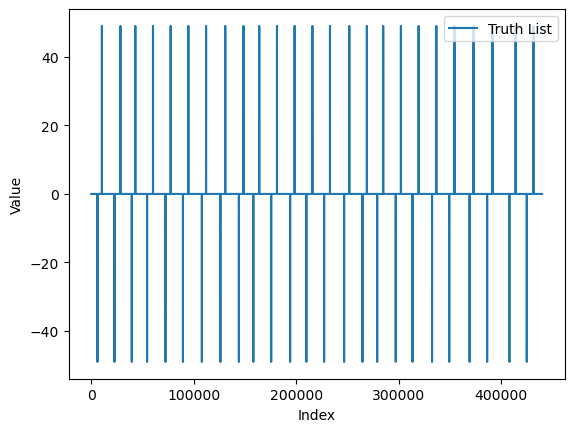

In [38]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(range(original_time_series_length)[:440000], truth_list[:440000], label='Truth List')
#plt.plot(range(original_time_series_length)[:100000], result_list[:100000], label='Predicted Result List')

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Display the plot
plt.show()






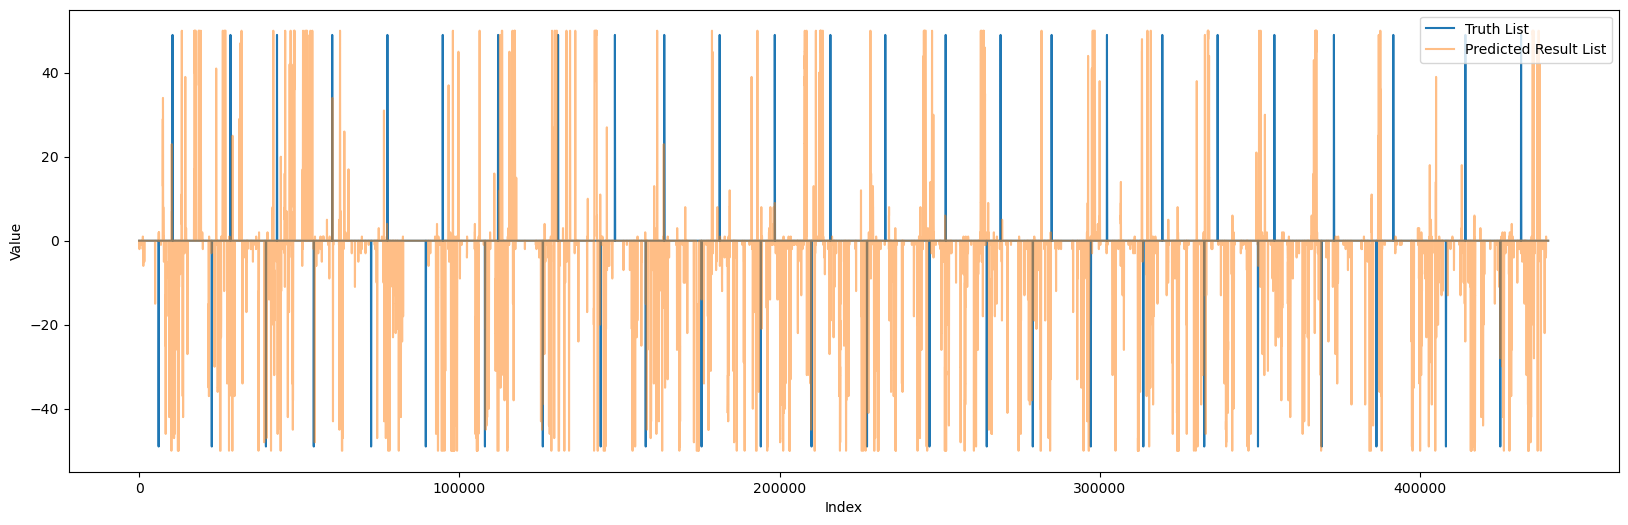

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
# Plotting
plt.plot(range(original_time_series_length)[:440000], truth_list[:440000], label='Truth List')
plt.plot(range(original_time_series_length)[:440000], result_list[:440000], label='Predicted Result List', alpha=0.5)

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Display the plot
plt.show()